# [java中的各种锁详细介绍](https://www.cnblogs.com/jyroy/p/11365935.html)

<details><summary>简介</summary>

加锁的含义不仅仅局限于互斥行为，还包括内存可见性。为了确保所有线程都能看到共享变量的最新值，所有执行读操作或者写操作的线程都必须在同一个锁上同步。
    
- 乐观锁/悲观锁
- 独享锁/共享锁
- 互斥锁/读写锁
- 可重入锁
- 公平锁/非公平锁
- 分段锁
- 偏向锁/轻量级锁/重量级锁
- 自旋锁

以上是一些锁的名词，这些分类并不是全是指锁的状态，有的指锁的特性，有的指锁的设计，下面总结的内容是对每个锁的名词进行一定的解释。

## 乐观锁/悲观锁
　　乐观锁与悲观锁并不是特指某两种类型的锁，是人们定义出来的概念或思想，主要是指看待并发同步的角度。

　　乐观锁：顾名思义，就是很乐观，每次去拿数据的时候都认为别人不会修改，所以不会上锁，但是在更新的时候会判断一下在此期间别人有没有去更新这个数据，可以使用版本号等机制。乐观锁适用于多读的应用类型，这样可以提高吞吐量，在Java中java.util.concurrent.atomic包下面的原子变量类就是使用了乐观锁的一种实现方式CAS(Compare and Swap 比较并交换)实现的。

　　悲观锁：总是假设最坏的情况，每次去拿数据的时候都认为别人会修改，所以每次在拿数据的时候都会上锁，这样别人想拿这个数据就会阻塞直到它拿到锁。比如**Java里面的同步原语synchronized关键字的实现就是悲观锁。**

　　**悲观锁适合写操作非常多的场景，乐观锁适合读操作非常多的场景，不加锁会带来大量的性能提升。**

　　悲观锁在Java中的使用，就是利用各种锁。

　　乐观锁在Java中的使用，是无锁编程，常常采用的是CAS算法，典型的例子就是原子类，通过CAS自旋实现原子操作的更新。

### 乐观锁
　　乐观锁总是认为不存在并发问题，每次去取数据的时候，总认为不会有其他线程对数据进行修改，因此不会上锁。但是在更新时会判断其他线程在这之前有没有对数据进行修改，一般会使用“数据版本机制”或“CAS操作”来实现。

（1） 数据版本机制
    
　　实现数据版本一般有两种，第一种是使用版本号，第二种是使用时间戳。以版本号方式为例。

　　版本号方式：一般是在数据表中加上一个数据版本号version字段，表示数据被修改的次数，当数据被修改时，version值会加一。当线程A要更新数据值时，在读取数据的同时也会读取version值，在提交更新时，若刚才读取到的version值为当前数据库中的version值相等时才更新，否则重试更新操作，直到更新成功。
核心SQL代码：
```sql
update table set xxx=#{xxx}, version=version+1 where id=#{id} and version=#{version};
```
（2） CAS操作
    
　　CAS（Compare and Swap 比较并交换），当多个线程尝试使用CAS同时更新同一个变量时，只有其中一个线程能更新变量的值，而其它线程都失败，失败的线程并不会被挂起，而是被告知这次竞争中失败，并可以再次尝试。

　　CAS操作中包含三个操作数——需要读写的内存位置(V)、进行比较的预期原值(A)和拟写入的新值(B)。如果内存位置V的值与预期原值A相匹配，那么处理器会自动将该位置值更新为新值B，否则处理器不做任何操作。

## 悲观锁
　　悲观锁认为对于同一个数据的并发操作，一定会发生修改的，哪怕没有修改，也会认为修改。因此对于同一份数据的并发操作，悲观锁采取加锁的形式。悲观的认为，不加锁并发操作一定会出问题。

　　在对任意记录进行修改前，先尝试为该记录加上排他锁（exclusive locking）。

　　如果加锁失败，说明该记录正在被修改，那么当前查询可能要等待或者抛出异常。具体响应方式由开发者根据实际需要决定。

　　如果成功加锁，那么就可以对记录做修改，事务完成后就会解锁了。

　　期间如果有其他对该记录做修改或加排他锁的操作，都会等待我们解锁或直接抛出异常。

## 独享锁/共享锁
　　独享锁是指该锁一次只能被一个线程所持有。

　　共享锁是指该锁可被多个线程所持有。

　　对于Java ReentrantLock而言，其是独享锁。但是对于Lock的另一个实现类ReadWriteLock，其读锁是共享锁，其写锁是独享锁。

　　读锁的共享锁可保证并发读是非常高效的，读写，写读，写写的过程是互斥的。

　　独享锁与共享锁也是通过AQS来实现的，通过实现不同的方法，来实现独享或者共享。

　　**对于Synchronized而言，当然是独享锁。**

## 互斥锁/读写锁
　　上面讲的独享锁/共享锁就是一种广义的说法，互斥锁/读写锁就是具体的实现。

　　互斥锁在Java中的具体实现就是ReentrantLock。

　　读写锁在Java中的具体实现就是ReadWriteLock。

## [可重入锁](https://blog.csdn.net/w8y56f/article/details/89554060)
　　可重入锁又名**递归锁**，是**指在同一个线程在外层方法获取锁的时候，在进入内层方法会自动获取锁。**说的有点抽象，通俗讲：**什么是 “可重入”，可重入就是说某个线程已经获得某个锁，可以再次获取锁而不会出现死锁。**下面会有一个代码的示例。

　　对于Java ReetrantLock而言，从名字就可以看出是一个重入锁，其名字是Re entrant Lock 重新进入锁。

　　对于Synchronized而言，也是一个可重入锁。可重入锁的一个好处是可一定程度避免死锁。

　　ReentrantLock 和 synchronized 不一样，需要手动释放锁，所以使用 ReentrantLock的时候一定要手动释放锁，并且加锁次数和释放次数要一样。

```java
synchronized void setA() throws Exception{
 　　Thread.sleep(1000);
 　　setB();
}
 
synchronized void setB() throws Exception{
 　　Thread.sleep(1000);
}
```
　　上面的代码就是一个可重入锁的一个特点。如果不是可重入锁的话，setB可能不会被当前线程执行，可能造成死锁。

## 公平锁/非公平锁
　　公平锁是指多个线程按照申请锁的顺序来获取锁。

　　非公平锁是指多个线程获取锁的顺序并不是按照申请锁的顺序，有可能后申请的线程比先申请的线程优先获取锁。有可能，会造成优先级反转或者饥饿现象。

　　对于Java ReetrantLock而言，通过构造函数指定该锁是否是公平锁，默认是非公平锁。非公平锁的优点在于吞吐量比公平锁大。

　　对于Synchronized而言，也是一种非公平锁。由于其并不像ReentrantLock是通过AQS的来实现线程调度，所以并没有任何办法使其变成公平锁。

## 分段锁
　　分段锁其实是一种锁的设计，并不是具体的一种锁，对于ConcurrentHashMap而言，其并发的实现就是通过分段锁的形式来实现高效的并发操作。

　　我们以ConcurrentHashMap来说一下分段锁的含义以及设计思想，ConcurrentHashMap中的分段锁称为Segment，它即类似于HashMap（JDK7和JDK8中HashMap的实现）的结构，即内部拥有一个Entry数组，数组中的每个元素又是一个链表；同时又是一个ReentrantLock（Segment继承了ReentrantLock）。

　　当需要put元素的时候，并不是对整个hashmap进行加锁，而是先通过hashcode来知道他要放在哪一个分段中，然后对这个分段进行加锁，所以当多线程put的时候，只要不是放在一个分段中，就实现了真正的并行的插入。

　　但是，在统计size的时候，可就是获取hashmap全局信息的时候，就需要获取所有的分段锁才能统计。

　　分段锁的设计目的是细化锁的粒度，当操作不需要更新整个数组的时候，就仅仅针对数组中的一项进行加锁操作。

## 偏向锁/轻量级锁/重量级锁
　　这三种锁是指锁的状态，并且是针对Synchronized。在Java 5通过引入锁升级的机制来实现高效Synchronized。这三种锁的状态是通过对象监视器在对象头中的字段来表明的。

　　偏向锁是指一段同步代码一直被一个线程所访问，那么该线程会自动获取锁。降低获取锁的代价。

　　轻量级锁是指当锁是偏向锁的时候，被另一个线程所访问，偏向锁就会升级为轻量级锁，其他线程会通过自旋的形式尝试获取锁，不会阻塞，提高性能。

　　重量级锁是指当锁为轻量级锁的时候，另一个线程虽然是自旋，但自旋不会一直持续下去，当自旋一定次数的时候，还没有获取到锁，就会进入阻塞，该锁膨胀为重量级锁。重量级锁会让他申请的线程进入阻塞，性能降低。

## 自旋锁
　　在Java中，自旋锁是指尝试获取锁的线程不会立即阻塞，而是采用循环的方式去尝试获取锁，这样的好处是减少线程上下文切换的消耗，缺点是循环会消耗CPU。
</details>

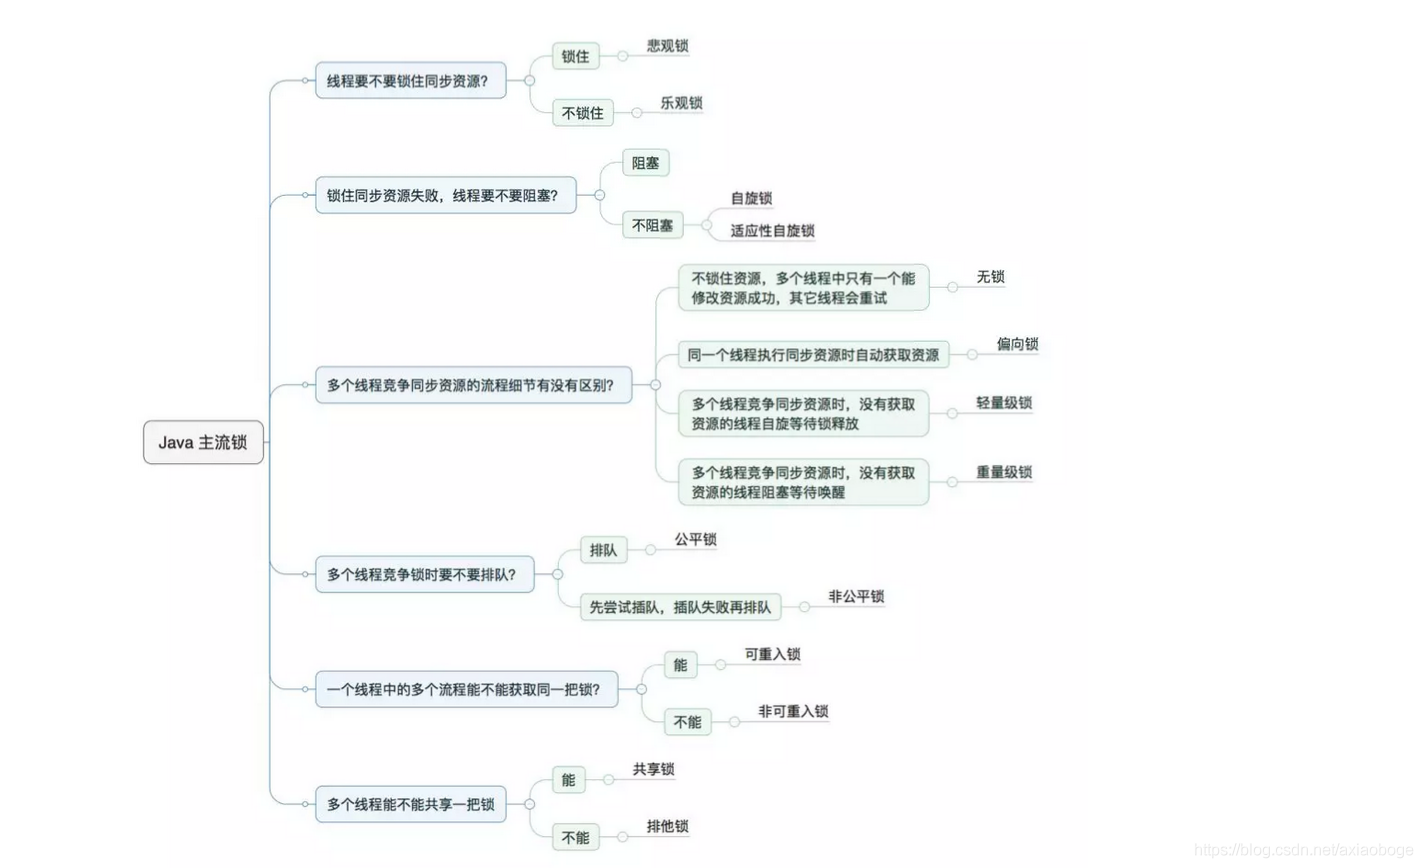